In [263]:
import os
import time
import datetime
import json
import numpy as np
import pandas as pd
from pathlib import Path

from PIL import Image
import seaborn as sns
import matplotlib.pyplot as plt
%matplotlib inline

import torch
from torch import nn
import torch.nn.functional as F
from torch.autograd import Variable
import torchvision.transforms as transforms
import torchvision.datasets as datasets
import torchvision.utils as vutils

from util.pos_embed import interpolate_pos_embed
import models_mae
import models_vit

print(np.__version__)
print(pd.__version__)
print(torch.__version__)

path_meta = Path('meta')
path_meta.mkdir(exist_ok=True, parents=True)
path_embeddings = Path('embedding')
path_embeddings.mkdir(exist_ok=True, parents=True)

1.22.2
1.4.1
1.10.2+cu113


### Purpose 目的
Identify the key features/dimensions that the model uses to make determinations in the classification task  

找出模型在分類任務中，用來做判定的關鍵特徵/維度

### How to find key features 如何找出關鍵特徵
- 將全世界的鳥類透過模型編碼(壓縮)成形狀為(1, dimension)的高維向量
    - 這個高維向量又稱為 embedding(representation, latent vector)
    - 在模型中以n=dimension組數值，編碼、描述鳥類的型態
    - 在ViT模型中， 圖塊嵌入(patch embedding)匯聚圖像資訊為類別表徵(cls embedding)，並使用cls embedding作為下游的分類任務使用 

- 借用<font color=lightgreen size=4> GradCam</font>概念，使用各類別(y)反向求導，求出對該類別有較大反應的導數所在維度(位於embedding的哪些維度上)

- 分類器
    - inputs: 
        - embedding。這裡使用cls embedding
    - outputs: 
        - classes。預測的類別
    - classifier:
        - ~~dense layer(full connected layers)*2~~
        - ViT內，在transformer模塊與外用來產生分類預測間是線性連結層，可以直接取出使用
            - transformer模塊外的最後兩層   
                - (norm): LayerNorm((768,), eps=1e-06, elementwise_affine=True)
                - [x] (head): Linear(in_features=768, out_features=1486, bias=True)
                <br><table align=left><tr><td bgcolor=green >注意!! head後沒有經過活化層，因此導數會得到負值</td></tr></table><br><br>

            - 使用目前下游分類任務表現最好的iNatFT encoder
                - (架構是使用eBirdPT NPon, cls_token的MAE encoder)  

- 關鍵特徵的決定採用投票方式
    - 採用iNatFT encoder的head(Linear layer)作為分類器(對應"種"層級的分類任務)
    - 使用GradeCam方法取得各個物種為單位的grad數值
    - 取得以"科"為單位的導數數值
        - 計算以科為單位的 mean/ medium    




## Get Linear Classifier from MAE encoder
- 使用目前下游分類任務表現最好的iNatFT encoder
    - (架構是使用eBirdPT NPon, cls_token的MAE encoder)  

In [28]:
encoder_version='iNatFT' # 'iNatFT' or 'eBirdPT'
norm_pixel = 'on'

global_pool = False
token = 'cls' if global_pool==False else 'gap'
data_src = 'iNat' #  'iNat', 'eBird'

ck_iNat_FT = 'ebird_NPon_FT_cls_vit_base_checkpoint-99.pth'       #　iNaturalist finetuned MAE

model_data_version = f'MAE_NP{norm_pixel}_{token}(Pretrain)_{encoder_version}(Encoder)_{data_src}(Data)'
print(f'Embedding version : {model_data_version}')
 

Embedding version : MAE_NPon_cls(Pretrain)_iNatFT(Encoder)_iNat(Data)


In [1206]:
def load_encoder(nb_classes:int=1486, global_pool:bool=False, encoder_version:str='iNat_FT', **kwargs):
    assert encoder_version == 'eBirdPT' or encoder_version =='iNatFT', f'Encoder_version must be either iNatFT or eBirdPT, got {encoder_version}'
    
    print(f'Encoder  : {encoder_version}')
    if encoder_version=='iNatFT':
        ck = Path('output_dir')/ck_iNat_FT 
    elif encoder_version=='eBirdPT':
        ck = Path('output_dir')/ck_eBird_PT
        
    model = models_vit.__dict__['vit_base_patch16'](
        num_classes=nb_classes, global_pool=global_pool, )
    checkpoint = torch.load(ck, map_location='cpu')
    

    print(f"Load pre-trained checkpoint from: {ck}")
    checkpoint_model = checkpoint['model']

    state_dict = model.state_dict()

    # interpolate position embedding
    interpolate_pos_embed(model, checkpoint_model)

    # load pre-trained model
    msg = model.load_state_dict(checkpoint_model, strict=False)
    print(msg)
    return model

model = load_encoder(encoder_version=encoder_version)
classifier = model.head
classifier

Encoder  : iNatFT
Load pre-trained checkpoint from: output_dir/ebird_NPon_FT_cls_vit_base_checkpoint-99.pth
<All keys matched successfully>


Linear(in_features=768, out_features=1486, bias=True)

## Get the gradient vectors(Degree of Concern about Features) 
找出分類器中，分類結果對於各維度的關注度(各類別反向傳播後的導數)
- 關注度
    - 模型根據預測結果反向傳播回去後，特徵(embedding)的導數。
    - 代表模型對該類別預測時，是根據那些特徵作為判斷依據
    - 有較大的數值(關注度/導數)表示，該權重位置(維度)對於分類器預測該類別是重要的
- 實作`get_grad()函式`
- 從線性分類器反向傳播中取得各類別對應的導數
- 以物種為單位

###  Implement the `get_grad()` function

In [410]:
F.one_hot(torch.tensor(labels) , num_classes=num_classes).shape

torch.Size([29720, 1486])

In [433]:
def get_grad(inputs:np.array, model, labels:np.array=None, **kwards)-> (torch.tensor, np.array):
    '''
    inputs : latent vectors /embeddings / features.  shape : (n_batch, dim)
    labels : labels of inputs. (Taxon unit such as : Species, Family, etc.) shape : (n_batch, n_classe)
    model(classifier) : simple fc layer
    outputs : gradients of inputs, label
    ''' 
    model.eval()
    model.zero_grad()
    
    # Set required gradients
    # features = inputs.clone().detach().requires_grad_(True)
    features = Variable(torch.tensor(inputs) , requires_grad=True)  
    pred = model(features)  # (n_batch, n_classe)
    
    # Whether to use the ground truth label, or predicted by the classifier
    if labels is None:                                
        labels = np.argmax(pred.detach().numpy(), axis=1)  # return (n_batch, n_classes)

    # one_hot encoding labels 
    one_hot = F.one_hot(torch.tensor(labels) , num_classes=num_classes) # (n_batch, n_classe)
    
    # Elementwise multiply of two matrix/vectors to get scalar, then do backpropogation
    # torch.mul(pred, one_hot).sum().backward() is same as pred.backward(one_hot) 
    pred.backward(one_hot)                             
    
    # grads of embeddings. shape:(n_batch, dim). 
    inputs_grad_ = features.grad.clone().detach().numpy()  
    
    return inputs_grad_, labels


In [52]:
# embeddings = np.load(path_embeddings/file_)['embedding']
# print(embeddings.shape)

(14860, 768)


### Prepare data(embeddings)
- pool iNat and eBird dataset

In [417]:
meta_data =  '../../shared/iNaturalist_2021/meta/val.csv'
df_meta =  pd.read_csv(meta_data, index_col=0)
# print(df_meta.columns)

# Establish sp_id 
df_meta['Sci_Name'] = df_meta.genus + '_' + df_meta.specific_epithet
sp_list = np.sort(df_meta.Sci_Name.unique())
mapping_dict = dict(zip(sp_list, range(sp_list.size)))
df_meta['sp_id'] = df_meta.Sci_Name.map(mapping_dict)

df_meta[['Sci_Name', 'sp_id']]

labels_sp_id = df_meta.sp_id
num_classes = labels_sp_id.nunique()

In [208]:
encoder_version='iNatFT' # 'iNatFT' or 'eBirdPT'
norm_pixel = 'on'

global_pool = False
token = 'cls' if global_pool==False else 'gap'
data_src = 'eBird' #  'iNat', 'eBird'

v_model_data = f'MAE_NP{norm_pixel}_{token}(Pretrain)_{encoder_version}(Encoder)_{data_src}(Data)'
v_model_data

'MAE_NPon_cls(Pretrain)_iNatFT(Encoder)_eBird(Data)'

In [341]:
embeddings_pool = [] 
for src_ in ['iNat', 'eBird']:
    file_ = f'embeddings_iNatureVal_{encoder_version}_{src_}.npz'
    embeddings_ = np.load(path_embeddings/file_)['embedding']
    embeddings_pool.append(embeddings_)
embeddings_pool  = np.concatenate(embeddings_pool) 

print(embeddings_pool.shape)
half = int(embeddings_pool.shape[0]/2) # 14860


labels_pool = list(labels_sp_id) + list(labels_sp_id)
assert len(embeddings_pool) == len(labels_pool)

data_src = 'pool'

(29720, 768)


### Get gradients from embeddings

In [436]:
# %%time

embeddings, labels = embeddings_pool, labels_pool

s = 0
slice
_ = 1000
# e = s + interval 
n_iter = int(np.ceil(embeddings.shape[0] / slice_))

labels_pred = [] 
start_time = time.time()
for i in range(n_iter):
    grads_, labels_ = get_grad(embeddings[s : s + slice_], 
                               classifier, 
                               labels=labels[s : s + slice_], 
                               num_classes=num_classes
                              )

    grads = grads_ if i==0 else np.concatenate([grads, grads_])
    labels_pred += labels_
    s += interval 

    passing_time = str(datetime.timedelta(seconds=int(time.time() - start_time )))
    info = f'Progress:{i+1:4,d}, {100*(i+1)/n_iter:6.2f}% ' 
    info += f'| Time: {passing_time}. | Grad_shape: {grads.shape}.' 
    print(info, end='\r')
    # break


In [860]:
file_grad = f'grad(withLabels)_eBirdPT_NP{norm_pixel}_{token}(Pretrain)_{encoder_version}(Finetune)_{data_src}(data)'

# np.savez_compressed(path_embeddings/f'{file_grad}.npz', gradients=grads)
# print(f'{file_grad} saved')

grads = np.load(path_embeddings/f'{file_grad}.npz')['gradients']
print(grads.shape)

(29720, 768)


CPU times: user 9.39 s, sys: 6.69 s, total: 16.1 s
Wall time: 660 ms


''

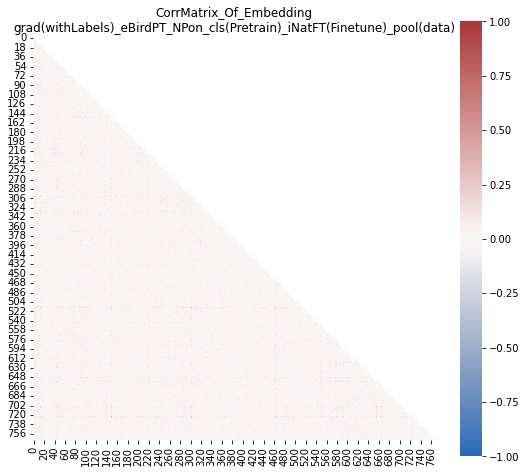

In [427]:
%%time

corr_matrix = np.corrcoef(np.transpose(grads))

# 取矩陣下半三角形
mask =  np.triu(np.ones_like(corr_matrix, dtype=bool))

title = f'CorrMatrix_Of_Embedding\n{file_grad}'
fig, ax = plt.subplots(figsize=(9, 8) )
ax.set_title(title)
sns.heatmap(corr_matrix, vmax=1, vmin=-1, center=0, square=True, 
            mask=mask,
            cmap='vlag', ax=ax)
# fig.savefig(f'embedding/{title}.jpg', bbox_inches='tight',)
;

/home/esslab/anaconda3/envs/mae/lib/python3.9/site-packages/pandas/plotting/_matplotlib/core.py:568: UserWarning: Attempted to set non-positive bottom ylim on a log-scaled axis.
Invalid limit will be ignored.
  ax.set_ylim(self.ylim)


''

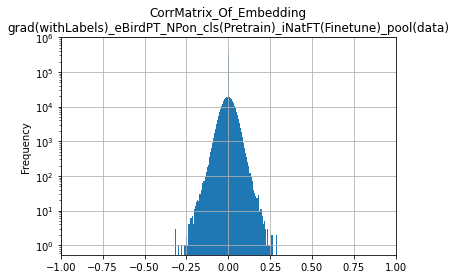

In [428]:
xlim=(-1,1)
ylim=(0,1e6)
# k=-1 ，排除斜對角的數值(均為1.0) 
fig = (pd.DataFrame(np.tril(corr_matrix ,k=-1))
       .stack()
       .plot(kind='hist', title=title, bins=100, grid=True, logy=True, xlim=xlim, ylim=ylim)
      ).get_figure()
# fig.savefig(f'embedding/{title}.jpg', bbox_inches='tight',)
;

## Determine key features by voting on 'Family' level
根據分類層級(科)投票決定關鍵特徵

### Mean of Concern Degree about Features on species/genus
- 找出每科的 top N 個重要分類特徵 (i.e. 對分科有最大影響力的 top N 維度)，並將所有科的重要特徵取聯集，得到 N-union 個關鍵特徵。我們視低維度的關鍵特徵為同時具有分辨力 (recognition) 與代表性 (representation) 的蛾標本影像特徵，並用於後續的分析與視覺化的解釋。
- 我們借用 Grad-CAM 的概念以找出分科的重要外觀特徵，透過反向傳播演算法 (back propagation) 求出分科模型中對應於每個輸入值的 gradient vector，是為特徵關注度向量。我們在此計算每個物種的平均特徵關注度，並以 voting 的方式，決定每個科的重要特徵。
- Voting 的規則是，先從物種平均特徵關注度的向量中，找出最大的 N 個值的位置，每個位置視為得到一票；接著算出每個科當中總得票最高的N個位置，即可選出 N 個重要特徵。最後將所有科的重要特徵取聯集，得到 N-union 個關鍵特徵。 

- 建立:科-物種"索引

In [1208]:
assert len(grads) == len(labels_pool)
df_meta_pool = pd.concat([df_meta, df_meta]).reset_index(drop=True)

In [1289]:
metric = 'Median' # 'Mean', 'Median'

In [1290]:

    
def pool_grads(grads, unit:str='Species', metric:str='Mean', df:pd.DataFrame=df_meta_pool ):
    if unit == 'Genus':
        taxon_list = np.sort(df_meta.genus.unique())
    elif unit == 'Species':
        taxon_list = np.sort(df_meta.Sci_Name.unique())
    
    for i, unit_ in enumerate(taxon_list):
        if unit == 'Genus':
            index  = df.query("genus == @unit_").index.values
        elif unit == 'Species':
            index  = df.query("Sci_Name == @unit_").index.values
            
        if metric == 'Median':
            grads_pool_ = np.median(np.abs(grads[index]), axis=0).reshape(1,-1)
        elif  metric == 'Mean':
            grad_pool_ = np.mean(np.abs(grads[index]), axis=0).reshape(1,-1)

        grads_pool = grads_pool_ if i == 0 else  np.concatenate([grads_pool_, grads_pool])
    
        print(f'{i:4,d}. shape : {grads_pool.shape} | Family : {family_:20s} - {unit} : {unit_:30s} ', end='\r')
    return grads_pool
    

- Species

In [1292]:
%%time
grads_sp_mean = pool_grads(grads, 'Species' , metric, df=df_meta_pool)
print('\n', grads_sp_mean.shape)

1,485. shape : (1486, 768) | Family : Zosteropidae         - Species : Zosterops_virens               
 (1486, 768)
CPU times: user 2.96 s, sys: 69.5 ms, total: 3.03 s
Wall time: 2.97 s


- Genus

In [1293]:
%%time
grads_genus_mean = pool_grads(grads, 'Genus' , metric, df=df_meta_pool)
print('\n', grads_genus_mean.shape)

 647. shape : (648, 768) | Family : Zosteropidae         - Genus : Zosterops                      
 (648, 768)
CPU times: user 1.28 s, sys: 20.3 ms, total: 1.3 s
Wall time: 1.28 s


### 找出關鍵特徵數量(N-union)
- 以最小但又具足夠鑑別度的 N 與 N-union 來描述與代表科的特徵。我們窮舉 N = 1 ~ n_topk 這個範圍中對應的 N-union 個關鍵特徵。
- 基於每個物種在關鍵特徵空間中的 embedding，依科計算分群的三個指標 (Silhouette Coefficient, Calinski and Harabasz score, 與 Davies-Bouldin score)
    - 標準化並加總評估後得到當 N=-, N-union=- 時有最佳的科分群結果，約為總特徵數的 - % (-/768)。

#### Convert the "Degree of Concern about Features" to "Key Features" on mean of species 

- 物種均值的特徵關注度(top_n)
    - 在物種層級指定top_n個重要維度
    - 蒐集對應top_n特徵對應的特徵位置指標
    - 依據top_n位置將關注度值轉為one_hot編碼(1 or 0)
    - 得到以物種均值為單位的one hot編碼格式的特徵關注度數值(即每個物種1票)
- 儲存 對應的 top_n: index_N of Spesies

In [1219]:
def one_hot_topk(inputs:np.array, n_topk:int)->np.array:
    '''
    encoding inputs(n, dim) to one_hot format(0 or 1) 
    threshod depends on quantile of topk for each sample
    encoding : x = 1 if x > q_topk else 0
    '''
    assert len(inputs.shape)==2
    n, dim = inputs.shape

    # calculate quantile of topk for each sample. 
    q_topk = np.quantile(inputs, q=(dim-n_topk)/dim, axis=1)   # shape : (n,)
    # broadcast quantile_topk from (n,) to (n, dim)
    q_topk = np.repeat(q_topk.reshape(n,-1), dim, axis=1)     
    # encoding : x = 1 if x > q_topk else 0
    
    inputs_one_hot_topk = np.where(inputs >= q_topk, 1, 0)

    
    return inputs_one_hot_topk


In [1352]:
unit = 'Genus' # 'Species' or 'Genus'
if unit == 'Genus':
    grads_mean = grads_genus_mean
elif unit == 'Species':
    grads_mean = grads_sp_mean


In [1403]:
%%time

n_topk = 50
grads_oh_topk = one_hot_topk(grads_mean, n_topk)
print(grads_oh_topk.shape)

# assert each sum of each dimension per data is equal to n_topk
assert (np.sum(grads_oh_topk, axis=1) == n_topk).all(), f'Sum in dim {np.where(np.sum(grads_oh_topk, axis=1) != n_topk)[0]}  \
is not equal to n_topk' 
# assert sorted index of each dimension per data is of "inputs" is same as "inputs_one_hot_topk"
assert (np.sort(np.argsort(grads_mean,)[:, -1 -(n_topk-1): ])  ==  
    np.sort(np.argsort(grads_oh_topk)[:, -1 -(n_topk-1): ])).all()

(648, 768)
CPU times: user 47.2 ms, sys: 348 µs, total: 47.6 ms
Wall time: 45.7 ms




####  Combine the key features of all families to obtain N-union key features
算出每個科當中總得票最高的N個位置，即可選出 N 個重要特徵。最後將所有科的重要特徵取聯集，得到 N-union 個關鍵特徵。
- 根據"科-物種"索引各科下各物種的top_n個重要維度
- 將各物種的top_n個重要維度透投票加總(one_hot編碼後每個物種/屬1票)
- 取得以科為單位的N-union重要維度
- ~~one_hot 編碼 科為單位的N-union重要維度~~
    - 排序各科前top_n重要維度(將投票數voting轉換為排序)
    - x = 1 if x > 0 else 0
- 儲存 對應的 top_n: index_N_union of Family
    

##### Voting on Family level

In [1404]:
if unit == 'Genus':
    family_index = (df_meta.groupby(['family', 'genus']).count().reset_index()[['family', 'genus']]) 
elif unit == 'Species':
    family_index = (df_meta.groupby(['family', 'Sci_Name']).count().reset_index()[['family', 'Sci_Name']])

In [1405]:
# Voting on Family level to get the key features of all families  
n, dim = grads_mean_topk.shape
for i, family_ in enumerate(family_index.family.unique()):
    index_fm = family_index.query("family == @family_").index.values
    voting_family_ = np.sum(grads_oh_topk[index_fm], axis=0).reshape(1, -1)  # (1, dim)
    # assert voting_family_.size ==  dim      # dim 
    
    voting_family = voting_family_ if i==0 else np.concatenate([voting_family_, voting_family])

    print(f'{i:3,d}. shape : {voting_family.shape} | Family : {family_:20s} ', end='\r')

print('\n', voting_family.shape)

146. shape : (147, 768) | Family : Zosteropidae         
 (147, 768)


- Calculate the n_topk positions with the highest total votes in each Family  
算出每個科當中總得票最高的N個位置

In [1406]:
index_ = np.argsort(voting_family, axis=1)[:, -n_topk:]
print(index_.shape)


(147, 50)


In [1407]:
voting_Fmy_oh_topk = one_hot_topk(voting_family, n_topk)

# assert each sum of each dimension per data is equal to n_topk
assert (np.sum(voting_Fmy_oh_topk, axis=1) == n_topk).all(), f'Sum in dim {np.where(np.sum(voting_Fmy_oh_topk, axis=1) != n_topk)[0]}  \
is not equal to n_topk' 
# assert sorted index of each dimension per data is of "inputs" is same as "inputs_one_hot_topk"
assert (np.sort(np.argsort(voting_family,)[:, -1 -(n_topk-1): ])  ==  
    np.sort(np.argsort(voting_Fmy_oh_topk)[:, -1 -(n_topk-1): ])).all()

AssertionError: Sum in dim [  1   5   6   7   8   9  10  11  12  14  15  16  19  21  24  28  30  31
  32  33  35  36  37  40  42  44  45  48  49  50  52  55  56  57  61  63
  65  68  70  71  72  73  74  77  81  82  83  84  86  88  89  91  95  96
  98  99 101 104 105 106 108 109 112 114 115 117 119 120 121 123 124 128
 130 131 133 137 138 139 140 142 143 144 145]  is not equal to n_topk

In [1408]:
np.sum(voting_Fmy_oh_topk, axis=1)

array([ 50,  94,  50,  50,  50,  89, 255,  95,  67, 113,  95,  74, 133,
        50,  96,  97,  72,  50,  50, 108,  50, 137,  50,  50, 155,  50,
        50,  50,  96,  50,  94, 139,  95, 135,  50,  95, 109,  94,  50,
        50, 180,  50, 255,  50, 209, 169,  50,  50,  98,  53,  99,  50,
        99,  50,  50, 141, 159, 257,  50,  50,  50,  96,  50,  98,  50,
        96,  50,  50,  72,  50, 180, 137, 142,  96, 215,  50,  50, 172,
        50,  50,  50, 142,  95,  98, 178,  50, 179,  50,  58, 111,  50,
       137,  50,  50,  50, 179,  76,  50, 182,  81,  50,  99,  50,  50,
        93, 140,  54,  50,  98, 143,  50,  50, 144,  50, 211, 173,  50,
       215,  50,  59, 178,  97,  50,  99, 176,  50,  50,  50, 137,  50,
       185,  52,  50, 141,  50,  50,  50, 119, 256,  92, 188,  50,  94,
        95,  72, 139,  50])

- ~~convert voting to n_topk key features~~

##### get N-union of key feature location on Family level  

In [1409]:
features_topk_families_voting = np.sum(voting_Fmy_oh_topk ,axis=0)  # (dim,)
index_n_union = np.where(features_topk_families_voting > 0)[0]
print(f'topk :  {n_topk} , N_union : {in
dex_n_union.size}')
# index_n_union

topk :  50 , N_union : 763


''

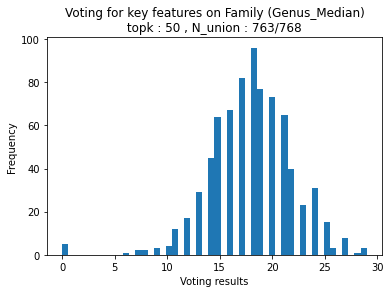

In [1410]:
ax = plt.axes()
ax.hist(features_topk_families_voting, bins=50)
title = f'Voting for key features on Family ({unit}_{metric})'
title += f'\n topk : {n_topk} , N_union : {index_n_union.size}/768 '
ax.set(title=title, xlabel='Voting results', ylabel='Frequency')
;

- 絕大部分維度voting後的數值均>0，亦即透過關鍵維度投票取得的聯集維度數量很大

---

In [ ]:
# n_topk = 50

# indexes = []
# index_n_unions = []

# start_time = time.time()
# for topk in np.arange(0, n_topk): # 取　1 - 50重要特徵
#     index_specie_topk = np.argsort(features_grad_mean)[:, -topk: ]  # (17186, topk) 物種平均特徵關注度的向量中，找出最大的 N 個值的位置
# #     print('index_specie_topk : ', index_specie_topk.shape)

#     # 根據指定的特徵數量( topk)，將指定位置的值轉為 1 ，其餘為0 (voting value = 1 )
#     features_topk_specie = np.zeros_like(features_grad_mean, dtype="uint16")
#     for i, index in enumerate(index_specie_topk):
#         features_topk_specie[i][index]=1
        
#     # 接著算出每個科當中總得票最高的N個位置，即可選出 N 個重要特徵。最後將所有科的重要特徵取聯集，得到 N-union 個關鍵特徵。
#     for k, family in fam_dict.items():
#         # 根據index位置篩選出該科所有物種，並進行加總，得到以科為單位、長度為1024維的向量
#         index_Family_Specie = df_Specie_Family[df_Specie_Family.Family == family].index.values
#         features_topk_family_ =  np.sum(features_topk_specie[index_Family_Specie], axis=0)     #  shape (1024,) 。 該科經過所有物種投票後得到的所有重要特徵維度 
#         if k==0:
#             features_topk_families_ = features_topk_family_.reshape(1, -1)
#         else:
#             features_topk_families_ = np.concatenate(
#                 (features_topk_families_, features_topk_family_.reshape(1, -1)),
#                 axis = 0
#             )
# #     print("features_topk_families : ", features_topk_families.shape)

#     # 這一步可能需要修正，應該只在物種層次取topk，科的層級則取聯集
#     index_family_topk = np.argsort(features_topk_families_)[:, -1 -(topk-1): ]  # (number of family, topk) 指定每個科當中總得票最高的N個位置(亦即各科 topk=N 個重要關鍵特徵位置) 
# #     print('index_family_topk : ', index_family_topk.shape)

#     # 根據指定的特徵數量( topk)，將指定位置的值轉為 1 ，其餘為0 (voting value = 1 )
#     features_topk_families = np.zeros_like(features_topk_families_, dtype="uint16")
    
#     for i, index in enumerate(index_family_topk):
#         features_topk_families[i][index]=1

#     features_topk_families_voting = np.sum(features_topk_families, axis=0)       # 求各科關鍵特徵的聯集 
#     index_ = np.where(features_topk_families_voting > 0)[0]                      # 取得 n_union指標位置(1024維)
#     index_n_union_ = np.where(index_ > 511, index_ - 512, index_)                # 轉換維原本維度(512維)
#     index_n_union = np.unique(index_n_union_)                                    # 去掉重複的維度 
    
#     indexes.append(index_)
#     index_n_unions.append(index_n_union)
    
#     time_pass = time.time()-start_time
#     print(f'Time: {time_pass/60%60 :.0f}m, {time_pass%60 :.0f}s. topk : {topk}, n_union : {len(index_n_union):3d} ', end="\r")

In [ ]:
np.save(f'embedding/index_n_unions.npy', index_n_unions)
index_n_unions = np.load(f'{path_root}/meta/index_n_unions.npy', allow_pickle=True)
df_Nuniun = pd.DataFrame([len(n) for n in index_n_unions], index=range(1,51), columns=["N_uniun"] )